### run_example_simulation.ipynb

This notebook runs the AL model with two short odor presentation that runs on a personal machine in the span of a minute, highlighting the main functions for circuit execution and visualization.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
project_dir = '../'
sys.path.append(project_dir)

from utils.data_utils import get_AL_activity_dfs
from utils.simulation_class import Sim
from utils.LIF_funcs_cython import run_LIF_general_sim_wrap as run_LIF, spikes_from_APMask
from utils.data_utils import set_connect_from_scale_dic
from utils.model_params import params as default_params
from utils.make_output_figures import plot_sim_spikes2, plot_AL_activity_dur_pre_odors
from utils.plot_utils import set_font_sizes
set_font_sizes()

Load connectomic information and imputed glomerulus x odor responses:

In [3]:
# default hemibrain data
hemibrain_dir = os.path.join(project_dir, 'connectomics/hemibrain_v1_2')
df_neur_ids = pd.read_csv(os.path.join(hemibrain_dir, 'df_neur_ids.csv'), index_col=0)
al_block = pd.read_csv(os.path.join(hemibrain_dir, 'AL_block.csv'), index_col=0)
imputed_glom_odor_table = pd.read_csv(os.path.join(project_dir, 'odor_imputation/df_odor_door_all_odors_imput_ALS.csv'), index_col=0)

Set odor presentation information:

In [4]:
# set ORN decay dynamics to mimic adaptation
decay_tc = 0.11 # seconds to half-height
decay_fadapt = 0.75 # a fraction of max height

# odors to present
odor_panel = ['3-octanol', '4-methylcyclohexanol']

# set up time array
n_odors = len(odor_panel)
stim_duration = 0.01
stim_pause = 0.005
trial_duration = stim_duration + stim_pause
end_time = (n_odors*trial_duration) + 0.001

Set multipliers onto cell type columns of the connectivity matrix (these particular ones were found by hand tuning to give reasonable AL features):

In [5]:
col_orn = 1
col_iln = 0.2
col_eln = 0.4
col_pn = 4

custom_scale_dic = {
    'ALL': 0.1,
    'otoo': col_orn, 'otoi': col_iln, 'otoe': col_eln, 'otop': col_pn,
    'itoo': col_orn, 'itoi': col_iln, 'itoe': col_eln, 'itop': col_pn,
    'etoo': col_orn, 'etoi': col_iln, 'etoe': col_eln, 'etop': col_pn,
    'ptoo': col_orn, 'ptoi': col_iln, 'ptoe': col_eln, 'ptop': col_pn,
   }

Initialize an instance of a Sim object that houses all simulation info:

In [6]:
sim = Sim(params = default_params,
      df_neur_ids=df_neur_ids, 
      al_block=al_block,
      model_name = 'example run',
      home_dir = project_dir,
      end_time = end_time,
      )

Add the odors into the Sim object:

In [7]:
# set up timings
t_odor_bounds = np.arange(0, end_time+0.01, trial_duration)
start_times = t_odor_bounds[:-1] + stim_pause
end_times = t_odor_bounds[1:]

# add odors according to their times
for i in range(n_odors):
    sim.add_odor(odor_name = odor_panel[i],
                 odor_start = start_times[i], 
                 odor_end = end_times[i],
                 tc = decay_tc,
                 fadapt = decay_fadapt,
                 imputed_glom_responses=imputed_glom_odor_table)

Set the timing of odor-evoked spikes on ORNs:

In [8]:
# set Iin
Iin = sim.make_Iin(is_input_PSC=True)

Set which LNs to flip to excitatory:

In [9]:
# set excitatory LN positions
np.random.seed(1234)
LN_bodyIds = df_neur_ids[df_neur_ids.altype == 'LN'].bodyId.values
num_LNs = len(LN_bodyIds)
num_eLNs = int(np.round(num_LNs / 6.4))
topk = int(np.round(num_LNs / 2))
nlns = len(LN_bodyIds)
elnpos = np.random.choice(np.arange(topk), num_eLNs, replace=False) 
print(elnpos)

# ### Set synapse strengths    
sim.set_eLNs(elnpos)

[63 36 54 62 78 85 55 57 44 92 29 40 33 61 39 59  1 56 71  9 79 27 66 72
 96 48 35 74  4 64 10]


Set the connectivity matrix multipliers from above:

In [10]:
# set scalars on class to class strengths
connect = set_connect_from_scale_dic(custom_scale_dic, sim)
sim.set_connect(connect.values)   

Run the leaky-integrate and fire simulator, and retrieve arrays of `num_neurons x num_timesteps` for voltages (`V`), currents (`I`), and indicators of when a neuron is undergoing a templated action potential (`APMask`):

(should run in about a minute)

In [11]:
# ### Run simulation
t0 = time.time()
print('running LIF...')
V, I, APMask = run_LIF(sim, Iin)
print('done running LIF')
tf = time.time()
print('elapsed', tf-t0)

running LIF...
done running LIF
elapsed 26.17527198791504


Get spike timings for all neurons via the action potential mask:

In [12]:
# count spikes
Spikes = spikes_from_APMask(APMask)

In [13]:
Spikes

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

For each odor, for each neuron, record firing rates in the time before the odor presentation, and during:

In [14]:
df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)

In [15]:
df_AL_activity.head()

,neur_name,neur_type,fr_pre_odor0,fr_dur_odor0,fr_pre_odor1,fr_dur_odor1,glom
0,ORN_DA1_0,ORN,0.0,100.0,0.0,100.0,DA1
1,ORN_DA1_1,ORN,0.0,0.0,0.0,0.0,DA1
2,ORN_DA1_2,ORN,0.0,0.0,0.0,100.0,DA1
3,ORN_DA1_3,ORN,0.0,0.0,0.0,0.0,DA1
4,ORN_DA1_4,ORN,0.0,0.0,0.0,100.0,DA1


For each cell type, plot firing rates of individual neurons before odors (left) and during odors (right)

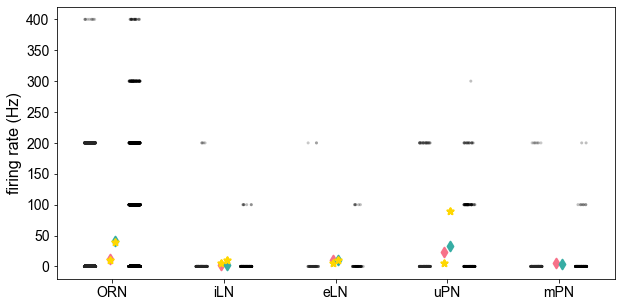

In [16]:
plt.figure(figsize=(10,5))
plot_AL_activity_dur_pre_odors(df_AL_activity_long)
plt.show()

At very short odor presentations, the plot above will look very discrete, since only a handful of spikes can be observed in a given time window.

Raster plot:

<Figure size 864x864 with 0 Axes>

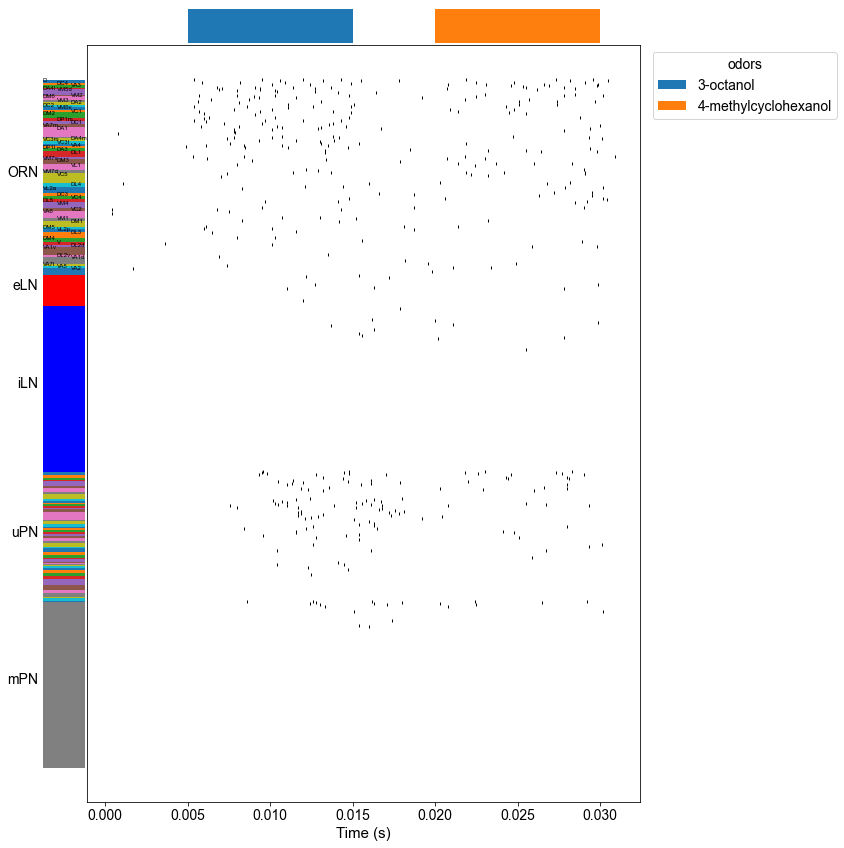

In [17]:
plt.figure(figsize=(12,12))
plot_sim_spikes2(sim, Spikes, df_AL_activity)
plt.show()